In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os

from tqdm.notebook import tqdm

In [2]:
data_fold = "../../../data/carla_sim/random_spawn"
exp_fold = "../../../data/experiments/carla_sim/random_spawn"

In [3]:
WIDTH, HEIGHT = 640, 480

N_SUBDIV_X = 2
N_SUBDIV_Y = 2
SUBDIV_WIDTH, SUBDIV_HEIGHT = WIDTH // N_SUBDIV_X, HEIGHT // N_SUBDIV_Y
N_DISCARD_TOP = 1
N_DISCARD_BOTTOM = 1
N_DISCARD_LEFT = 1
N_DISCARD_RIGHT = 1

T_STEPS = 200

T_STEPS_T_COLL_MAX = 100  # number of time steps before collision to consider as a positive output if a collision occurs in the sequence

In [4]:
class SigmoidScaleBias(nn.Module):
    def __init__(self, dim, scale=True, bias=True, single_param=False):
        super().__init__()
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)
        if scale:
            self.scale = nn.Parameter(torch.Tensor(1 if single_param else dim))
        else:
            self.register_parameter('scale', None)
        
        if self.bias is not None:
            self.bias.data.uniform_(0, 0)

        if self.scale is not None:
            self.scale.data.uniform_(1, 1)

    def forward(self, input):
        output = input
        if self.scale is not None:
            output *= self.scale.unsqueeze(0).expand_as(output)
        if self.bias is not None:
            output -= self.bias.unsqueeze(0).expand_as(output)
        return torch.sigmoid(output)

In [5]:
class Net(nn.Module):
    def __init__(
        self,
        width=SUBDIV_WIDTH,
        height=SUBDIV_HEIGHT,
        kern_half_size=3,
        rmo_head=True,
        sigm_kern=0.3,
        reg=1.5,
        dt=10.0,
        r_out_sigm_scale=500.0,
        r_out_scale=500.0,
        train_weights=True,
        size_layers=[10],
        use_dropout=False,
        train_kernels=False,
    ):
        super().__init__()

        self.width = width
        self.height = height
        self.kern_half_size = kern_half_size
        self.size_layers = (
            size_layers if isinstance(size_layers, list) else [size_layers]
        )
        self.kern_size = 2 * kern_half_size + 1

        self.sigm_kern = sigm_kern

        #self.reg = nn.Parameter(torch.tensor([reg]).float())
        self.reg = reg

        #self.r_out_sigm_scale = nn.Parameter(torch.tensor([r_out_sigm_scale]).float())

        self.dt = dt

        self.train_weights = train_weights

        self.rmo_head = rmo_head
        self.use_dropout = use_dropout

        _x, _y = np.meshgrid(
            np.arange(-kern_half_size, kern_half_size + 1),
            np.arange(-kern_half_size, kern_half_size + 1),
        )

        self.kern_x = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_y = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_norm = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        _gauss = np.exp(-(_x**2 + _y**2) / (2.0 * (sigm_kern * kern_half_size) ** 2))
        _gauss /= _gauss.sum()

        with torch.no_grad():

            self.kern_norm.weight.data = nn.Parameter(
                torch.tensor(_gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_norm.weight.requires_grad = train_kernels

            self.kern_x.weight.data = nn.Parameter(
                torch.tensor(_x * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_x.weight.requires_grad = train_kernels

            self.kern_y.weight.data = nn.Parameter(
                torch.tensor(_y * _gauss).float().unsqueeze(0).unsqueeze(0),
            )
            self.kern_y.weight.requires_grad = train_kernels

        self.vx = torch.zeros((1, 1, height, width)).float()
        self.vy = torch.zeros((1, 1, height, width)).float()

        _x, _y = np.meshgrid(
            np.linspace(-1, 1, width),
            np.linspace(-height / width, height / width, height),
        )

        with torch.no_grad():
            self.wx = nn.Parameter(torch.tensor(_x).float().unsqueeze(0).unsqueeze(0))
            self.wx.requires_grad = self.train_weights
            self.wy = nn.Parameter(torch.tensor(_y).float().unsqueeze(0).unsqueeze(0))
            self.wy.requires_grad = self.train_weights

            #self.wx = nn.Parameter(torch.zeros((1, 1, height, width)))
            #self.wy = nn.Parameter(torch.zeros((1, 1, height, width)))

        """
        self.layers = []

        self.layers.append(nn.Flatten())

        if len(size_layers) > 0:
            for i in range(len(size_layers)):
                if i == 0:
                    self.layers.append(nn.Linear(width * height, size_layers[i]))
                else:
                    self.layers.append(nn.Linear(size_layers[i - 1], size_layers[i]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(size_layers[-1], 1))
        else:
            self.layers.append(nn.Linear(width * height, 1))

        self.layers = nn.Sequential(*self.layers)
        """
        self.fwd = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width * height, 2, bias=False),
        )

        w_pos = np.exp(-_x**2. / (2. * 0.25 ** 2)) * np.exp(-_y**2. / (2. * 0.25 ** 2))
        w_pos_left = np.zeros_like(w_pos)
        w_pos_left[:, :width // 2] = w_pos[:, :width // 2]
        #w_pos_left /= w_pos_left.sum()
        w_pos_right = np.zeros_like(w_pos)
        w_pos_right[:, width // 2:] = w_pos[:, width // 2:]
        #w_pos_right /= w_pos_right.sum()

        with torch.no_grad():
            self.fwd[1].weight.data[0] = nn.Parameter(torch.tensor(w_pos_left.flatten()).float())
            self.fwd[1].weight.data[1] = nn.Parameter(torch.tensor(w_pos_right.flatten()).float())
            self.fwd[1].weight.requires_grad = self.train_weights

        #with torch.no_grad():
        #    self.fwd[1].weight.data[0] = nn.Parameter(torch.tensor((_x < 0.0).flatten()).float())
        #    self.fwd[1].weight.data[1] = nn.Parameter(torch.tensor((_x > 0.0).flatten()).float())


        self.sigm = SigmoidScaleBias(2, single_param=True)

        with torch.no_grad():
            self.sigm.scale = nn.Parameter(torch.tensor([r_out_sigm_scale]).float())

        self.out_scale = nn.Parameter(torch.tensor([r_out_scale]).float())

        self.out_th = nn.Parameter(torch.zeros((1)).float())

        if self.use_dropout:
            self.dropout = nn.Dropout(self.use_dropout)

    def forward(self, x):
        x_p = (x > 0).float()
        x_n = (x < 0).float()

        if self.use_dropout:
            x_p = self.dropout(x_p)
            x_n = self.dropout(x_n)

        I_x_p_prev = self.kern_x(x_p[..., 0:1, :, :])
        I_y_p_prev = self.kern_y(x_p[..., 0:1, :, :])
        I_norm_p_prev = self.kern_norm(x_p[..., 0:1, :, :])

        vx_p = -x_p[..., 1:2, :, :] * I_x_p_prev * self.dt / (self.reg**2 + I_norm_p_prev * self.dt**2)
        vy_p = -x_p[..., 1:2, :, :] * I_y_p_prev * self.dt / (self.reg**2 + I_norm_p_prev * self.dt**2)

        I_x_n_prev = self.kern_x(x_n[..., 0:1, :, :])
        I_y_n_prev = self.kern_y(x_n[..., 0:1, :, :])
        I_norm_n_prev = self.kern_norm(x_n[..., 0:1, :, :])

        vx_n = -x_n[..., 1:2, :, :] * I_x_n_prev * self.dt / (self.reg**2 + I_norm_n_prev * self.dt**2)
        vy_n = -x_n[..., 1:2, :, :] * I_y_n_prev * self.dt / (self.reg**2 + I_norm_n_prev * self.dt**2)

        self.vx = vx_p + vx_n
        self.vy = vy_p + vy_n

        v_project = self.vx * self.wx + self.vy * self.wy

        #left_right = self.r_out_scale * self.fwd(v_project)
        left_right = self.fwd(v_project)

        if self.rmo_head:
            out = self.out_scale * torch.min(left_right, dim=1).values * torch.prod(self.sigm(left_right), dim=1) - self.out_th
        else:
            out = self.out_scale * left_right.mean(dim=1) - self.out_th
        #

        return out
        #return self.layers(v_project)

In [6]:
def load_metadata(fold, t_steps):
    samples = [f for f in os.listdir(fold) if f.startswith("example")]
    samples.sort(key=lambda x: int(x.split("_")[1]))

    labels = []
    metadata = []

    samples_filtered = []

    for sample in samples:
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        sample_steps = int(metadat["t_end"] // metadat["dt"])

        if sample_steps < t_steps:
            continue
        
        samples_filtered.append(sample)

        labels.append(int(metadat["coll_type"] != "none"))

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return samples_filtered, labels, metadata

In [29]:
smpls, lbls, md = load_metadata(data_fold, T_STEPS)

In [31]:
N_SAMPLES = 250

assert N_SAMPLES <= len(smpls)

inds = np.arange(len(smpls))
np.random.shuffle(inds)

#inds = np.load(os.path.join(exp_fold, "idxs.npy"))

N_TRAIN = int(0.25 * N_SAMPLES)
N_VAL = int(0.25 * N_SAMPLES)
N_TEST = N_SAMPLES - N_TRAIN - N_VAL

smpls_train = [smpls[i] for i in inds[:N_TRAIN]]
smpls_val = [smpls[i] for i in inds[N_TRAIN:N_TRAIN + N_VAL]]
smpls_test = [smpls[i] for i in inds[N_TRAIN + N_VAL:N_SAMPLES]]

In [98]:
np.save(os.path.join(exp_fold, "idxs.npy"), inds)

np.savez(os.path.join(exp_fold, "samples.npz"), train=smpls_train, val=smpls_val, test=smpls_test)

In [33]:
def load_raw_data(fold, samples):
    labels = []
    metadata = []
    data = []

    mem_gb = 0

    for sample in samples:
        events = np.load(os.path.join(fold, sample, "events.npy"))
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        labels.append(int(metadat["coll_type"] != "none"))

        data.append(events)

        mem_gb += events.nbytes / 1e9
        print(f"Total estimate of event data size: {mem_gb:.2f} GB", end="\r")

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return data, labels, metadata

In [34]:
data_train, lbls_train, md_train = load_raw_data(data_fold, smpls_train)
data_val, lbls_val, md_val = load_raw_data(data_fold, smpls_val)
data_test, lbls_test, md_test = load_raw_data(data_fold, smpls_test)

In [37]:
len(data_train)

62

In [38]:
def convert_to_tens(data, labels, metadata, t_steps):
    X = []

    idx_drop = []
    for i, events in tqdm(enumerate(data)):
        dt = metadata[i]["dt"]
        t_end = metadata[i]["t_end_ms"]
        nt = int(t_end / dt)
        if nt < t_steps:
            idx_drop.append(i)
            print(f"Sample {i} has too few frames, dropping it.")
            continue
        _dat = torch.zeros(t_steps, SUBDIV_HEIGHT, SUBDIV_WIDTH).type(torch.int8)
        for t in tqdm(range(t_steps), leave=False):
            _evts = events[
                (events["t"] >= (t + nt - t_steps) * dt)
                & (events["t"] < (t + 1 + nt - t_steps) * dt)
                & (events["y"] >= N_DISCARD_TOP * SUBDIV_HEIGHT // 2)
                & (events["y"] < HEIGHT - N_DISCARD_BOTTOM * SUBDIV_HEIGHT // 2)
                & (events["x"] >= N_DISCARD_LEFT * SUBDIV_WIDTH // 2)
                & (events["x"] < WIDTH - N_DISCARD_RIGHT * SUBDIV_WIDTH // 2)
            ]
            _dat[
                t,
                _evts["y"] - N_DISCARD_TOP * SUBDIV_HEIGHT // 2,
                _evts["x"] - N_DISCARD_LEFT * SUBDIV_WIDTH // 2,
            ] = torch.tensor(2 * _evts["p"].astype(int) - 1).type(torch.int8)
        X.append(_dat)

    X = torch.stack(X)

    labels = torch.tensor([labels[i] for i in range(len(labels)) if i not in idx_drop]).type(torch.int8)
    metadata = [metadata[i] for i in range(len(metadata)) if i not in idx_drop]

    return X, labels, metadata
    

In [39]:
X_train, y_train, md_train = convert_to_tens(data_train, lbls_train, md_train, T_STEPS)
assert len(lbls_train) == len(y_train)
X_val, y_val, md_val = convert_to_tens(data_val, lbls_val, md_val, T_STEPS)
assert len(lbls_val) == len(y_val)
X_test, y_test, md_test = convert_to_tens(data_test, lbls_test, md_test, T_STEPS)
assert len(lbls_test) == len(y_test)

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
try:
    torch.save(X_train, os.path.join(exp_fold, "X_train.pt"))
    torch.save(y_train, os.path.join(exp_fold, "y_train.pt"))
    torch.save(md_train, os.path.join(exp_fold, "md_train.pt"))

    torch.save(X_val, os.path.join(exp_fold, "X_val.pt"))
    torch.save(y_val, os.path.join(exp_fold, "y_val.pt"))
    torch.save(md_val, os.path.join(exp_fold, "md_val.pt"))

    torch.save(X_test, os.path.join(exp_fold, "X_test.pt"))
    torch.save(y_test, os.path.join(exp_fold, "y_test.pt"))
    torch.save(md_test, os.path.join(exp_fold, "md_test.pt"))
except Exception as e:
    print(e)

In [57]:
X_train = torch.load(os.path.join(exp_fold, "X_train.pt"))
X_val = torch.load(os.path.join(exp_fold, "X_val.pt"))
X_test = torch.load(os.path.join(exp_fold, "X_test.pt"))

y_train = torch.load(os.path.join(exp_fold, "y_train.pt"))
y_val = torch.load(os.path.join(exp_fold, "y_val.pt"))
y_test = torch.load(os.path.join(exp_fold, "y_test.pt"))

/tmp/ipykernel_114582/3300472960.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load(os.path.join(exp_fold, "X_train.pt"))
/tmp/ipykernel_114582/3300472

In [61]:
def gen_x_sequ(X, Y, t_steps_to_coll_max=None):
    _t_steps = X.shape[1]
    X_1 = X[:,1:,...]
    X_0 = X[:,:-1,...]
    X_seq = torch.stack([X_0, X_1], dim=2)
    X_seq = X_seq.view(-1, X_seq.shape[-3], X_seq.shape[-2], X_seq.shape[-1])
    
    Y_expand = Y.unsqueeze(1).repeat(1,_t_steps-1)#.flatten()
    if t_steps_to_coll_max is not None:
        Y_expand[:,:-t_steps_to_coll_max] = 0
    Y_expand = Y_expand.flatten()

    return X_seq, Y_expand

In [62]:
X_seq_train, y_seq_train = gen_x_sequ(X_train, y_train, T_STEPS_T_COLL_MAX)
X_seq_val, y_seq_val = gen_x_sequ(X_val, y_val, T_STEPS_T_COLL_MAX)
X_seq_test, y_seq_test = gen_x_sequ(X_test, y_test, T_STEPS_T_COLL_MAX)

In [63]:
# create dataloaders

train_data = torch.utils.data.TensorDataset(X_seq_train, y_seq_train)
val_data = torch.utils.data.TensorDataset(X_seq_val, y_seq_val)
test_data = torch.utils.data.TensorDataset(X_seq_test, y_seq_test)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(
    kern_half_size=2,
    sigm_kern=0.3,
    reg=0.1,
    r_out_sigm_scale=1.0,
    r_out_scale=1.0,
    size_layers=[],
    rmo_head=True,
    use_dropout=0.02,
    train_kernels=False,
    train_weights=False,
)
net.to(device)

Net(
  (kern_x): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (kern_y): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (kern_norm): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (fwd): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=76800, out_features=2, bias=False)
  )
  (sigm): SigmoidScaleBias()
  (dropout): Dropout(p=0.02, inplace=False)
)

In [65]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

N_EPOCHS = 25

train_losses = []
val_losses = []


for epoch in range(N_EPOCHS):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            val_loss += loss_fn(outputs.flatten(), labels.float()).item()
        
    val_losses.append(val_loss / len(val_loader))
    print(f"Validation loss: {val_loss / len(val_loader)}")

Epoch 1, loss: 0.5866657510940275
Validation loss: 0.5270839727066283
Epoch 2, loss: 0.5025069207107465
Validation loss: 0.46548965562091554
Epoch 3, loss: 0.45240845859359585
Validation loss: 0.42506996643038253
Epoch 4, loss: 0.41918287808413335
Validation loss: 0.39725776138375246
Epoch 5, loss: 0.39652801057989734
Validation loss: 0.3783710304598826
Epoch 6, loss: 0.38168704258808817
Validation loss: 0.36566035727363494
Epoch 7, loss: 0.37226251022494516
Validation loss: 0.3571685700927809
Epoch 8, loss: 0.3659950879262519
Validation loss: 0.35144647621373837
Epoch 9, loss: 0.36200046743908076
Validation loss: 0.34761738164483547
Epoch 10, loss: 0.3596629581071552
Validation loss: 0.3449391110545284
Epoch 11, loss: 0.35772742585814676
Validation loss: 0.34317931224502457
Epoch 12, loss: 0.3565839415155544
Validation loss: 0.34192961184449683
Epoch 13, loss: 0.355580044302298
Validation loss: 0.34106676034850114
Epoch 14, loss: 0.3555216521333536
Validation loss: 0.3404230327551118


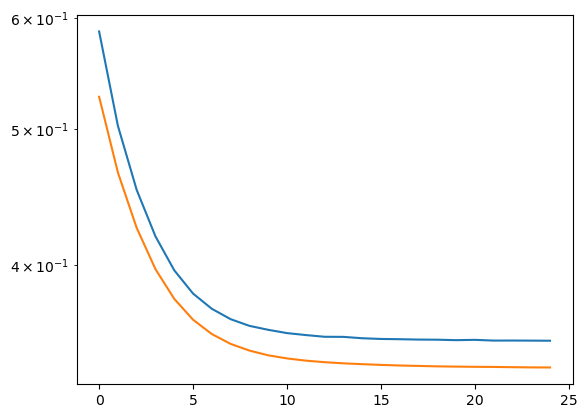

In [69]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.yscale("log")
#plt.xscale("log")
plt.show()

In [70]:
# test the model

net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        predicted = (outputs > 0).int()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test set: {100 * correct / total}%")

Accuracy of the network on the test set: 86.79508654383027%


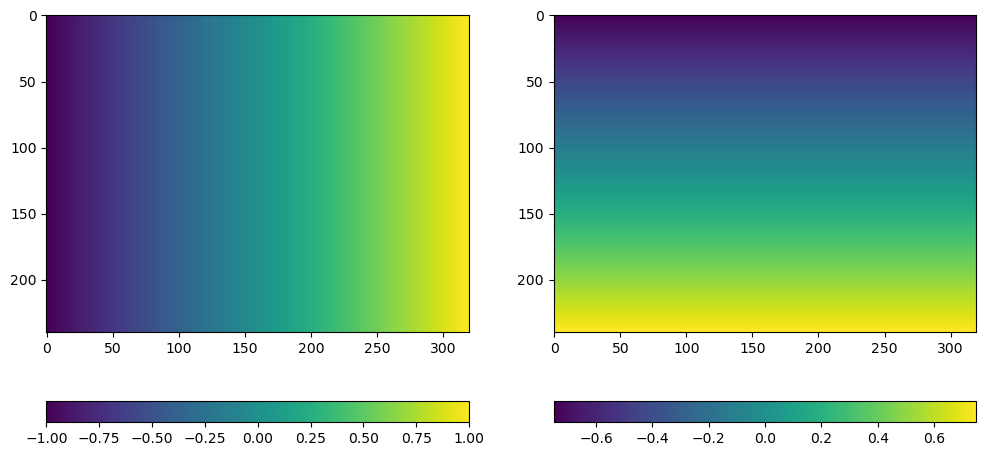

In [16]:
net.eval()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img0 = ax[0].imshow(net.wx.detach().cpu().numpy().squeeze())
plt.colorbar(img0, ax=ax[0], orientation="horizontal")

img1 = ax[1].imshow(net.wy.detach().cpu().numpy().squeeze())
plt.colorbar(img1, ax=ax[1], orientation="horizontal")

plt.show()

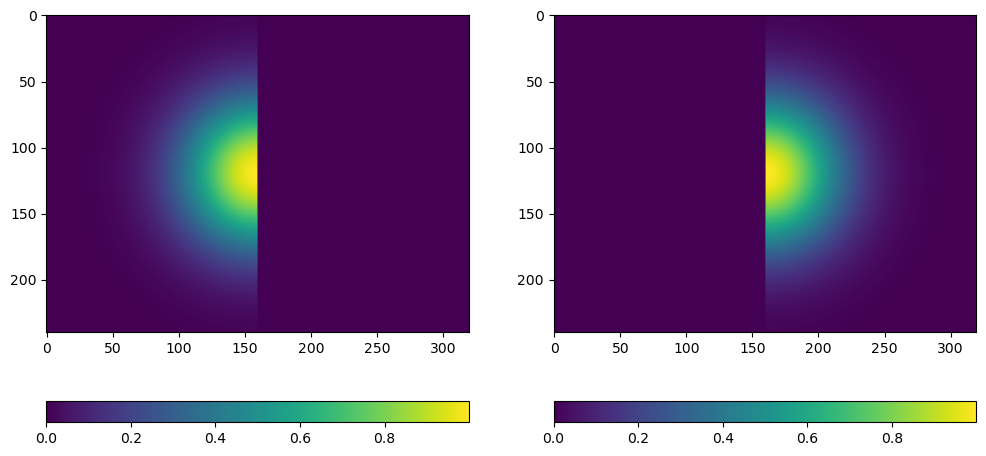

In [17]:
net.eval()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img0 = ax[0].imshow(net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img0, ax=ax[0], orientation="horizontal")

img1 = ax[1].imshow(net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img1, ax=ax[1], orientation="horizontal")

plt.show()

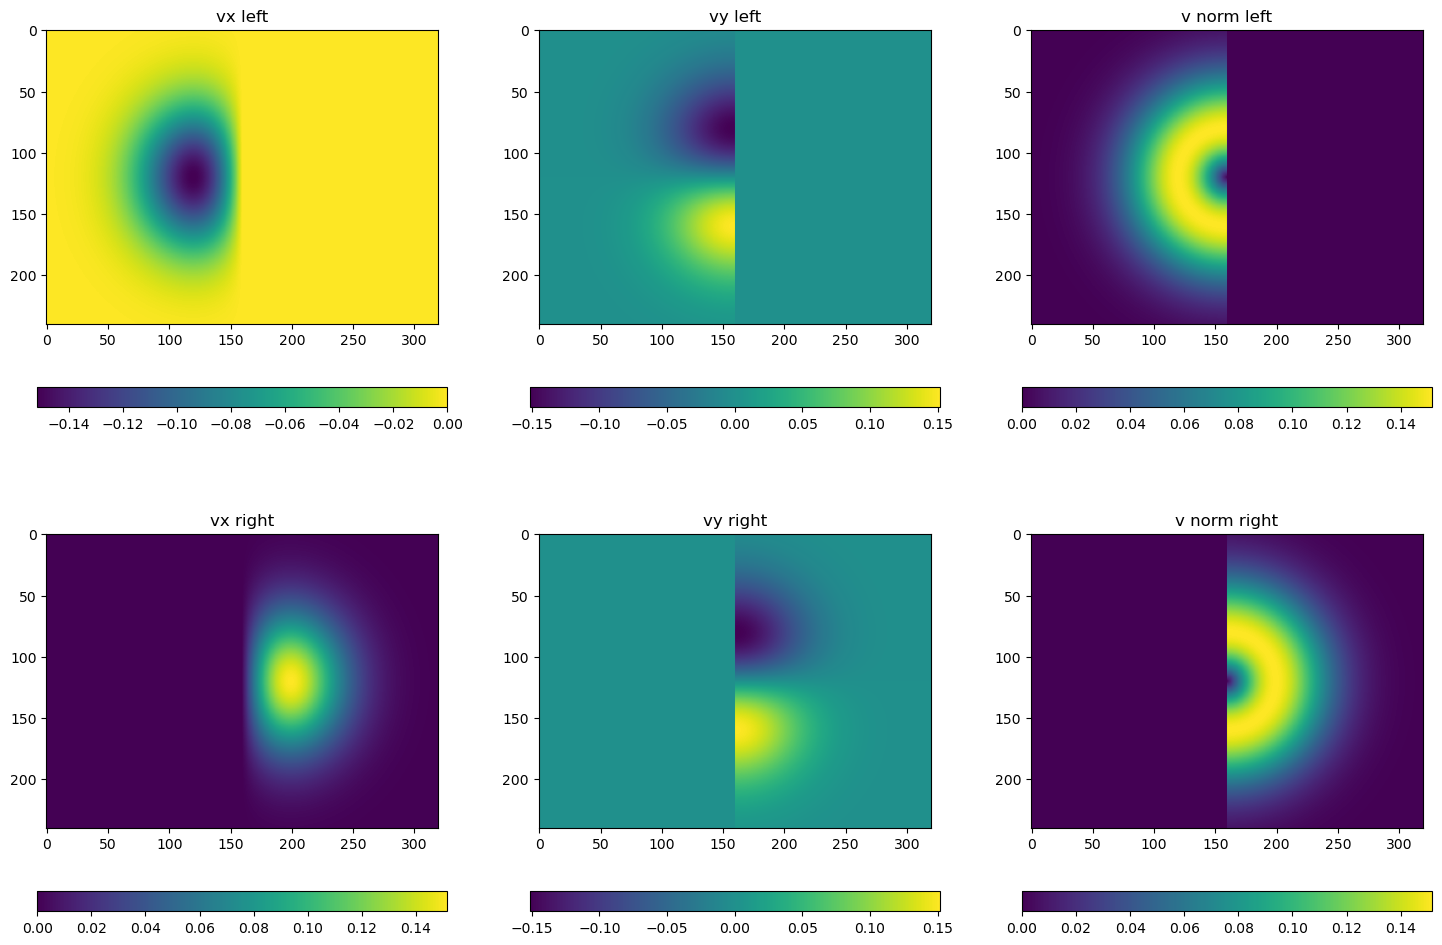

In [18]:
net.eval()

fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax = ax.flatten()

img0 = ax[0].imshow(net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img0, ax=ax[0], orientation="horizontal")
ax[0].set_title("vx left")

img1 = ax[1].imshow(net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img1, ax=ax[1], orientation="horizontal")
ax[1].set_title("vy left")

img_norm1 = ax[2].imshow(
    np.sqrt((net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2 +
            (net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[0].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2
            )
        )
plt.colorbar(img_norm1, ax=ax[2], orientation="horizontal")
ax[2].set_title("v norm left")


img2 = ax[3].imshow(net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img2, ax=ax[3], orientation="horizontal")
ax[3].set_title("vx right")

img3 = ax[4].imshow(net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))
plt.colorbar(img3, ax=ax[4], orientation="horizontal")
ax[4].set_title("vy right")

img_norm2 = ax[5].imshow(
    np.sqrt((net.wy.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2 +
            (net.wx.detach().cpu().numpy().squeeze() * net.fwd[1].weight.detach().cpu().numpy()[1].reshape(SUBDIV_HEIGHT, SUBDIV_WIDTH))**2
            )
        )
plt.colorbar(img_norm1, ax=ax[5], orientation="horizontal")
ax[5].set_title("v norm right")

plt.show()

33
1


/tmp/ipykernel_114582/593883673.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = _o


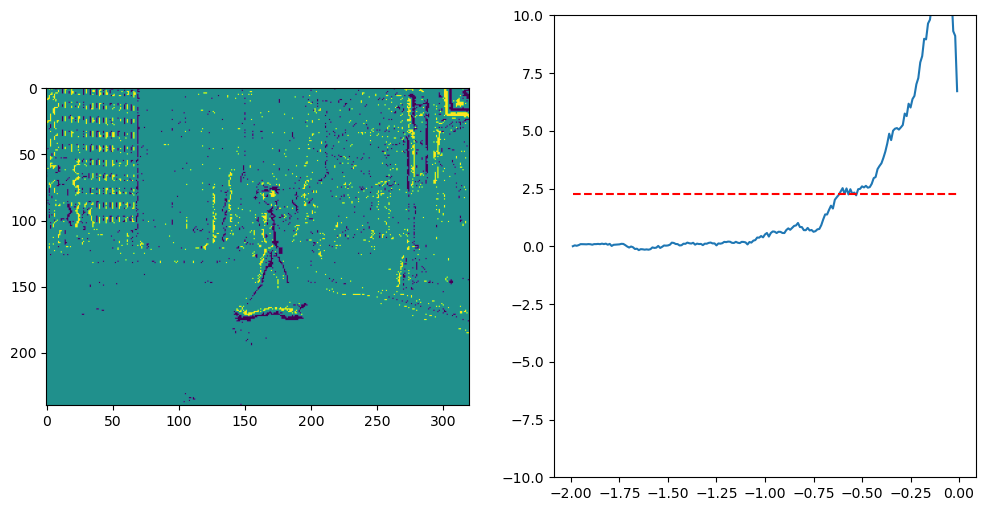

In [93]:
search_for = 1

while True:
    sample = np.random.randint(0, X_test.shape[0])
    if y_test[sample] == search_for:
        break

print(sample)
print(y_test[sample].detach().cpu().numpy())

steps = T_STEPS - 1

net.eval()
out = np.zeros((steps))
_o = 0.0
with torch.no_grad():
    for k in range(steps):
        img = torch.stack([X_test[sample,k,...], X_test[sample,k+1,...]], dim=0).float().to(device)
        #for i in range(_evts.shape[0]):
        #_o = net(img).detach().cpu().numpy()
        #_o = 0.95 * _o + 0.05 * (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        _o = 0.75 * _o + 0.25 * (net(img).detach().cpu().numpy() + net.out_th.detach().cpu().numpy())
        #_o = (1. + np.tanh(0.5 * net(img).detach().cpu().numpy())) / 2.
        out[k] = _o


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(X_test[sample,130,:,:].detach().numpy())

t_ax = (np.arange(1-T_STEPS,0) * md_test[sample]["dt"] / 1000)[:steps]
ax[1].plot(t_ax, out)

ax[1].hlines(net.out_th.detach().cpu().numpy(), t_ax[0], t_ax[-1], color="r", linestyle="--")
ax[1].set_ylim(-.1,1.1)
ax[1].set_ylim(-10.,10.)

plt.show()

In [94]:
net.eval()
net.reg

0.1

In [95]:
net.eval()
net.sigm.bias.detach().cpu().numpy()

array([-0.9147751], dtype=float32)

In [96]:
net.eval()
net.sigm.scale.detach().cpu().numpy()

array([1.5685232], dtype=float32)

In [97]:
net.eval()
net.out_scale.detach().cpu().numpy()

array([1.6238418], dtype=float32)

In [60]:
net.eval()
net.out_th.detach().cpu().numpy()

array([2.321673], dtype=float32)